# Chapter 6: Spark MLlib
## Lab assignment: Example with the MLlib

The aim of this notebook is to play with the MLlib of Apache Spark to create a Machine Learning pipeline that preprocesses a dataset, trains a model and makes predictions. In particular, we are going to deal with a regression problem for energy consumption prediction. The content of this lab is very much inspired by the sample provided in the [databricks documentation](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2854662143668609/2084788691983918/6837869239396014/latest.html). We believe this is a fantastic resource to get started with the MLlib, and we have decided to extend it and align it with Chapter 6 of our book. Throughout this notebook you will have to complete all the steps to learn from the data, ranging from loading the data and preprocessing it to learn a model and evaluate the results. To do this, we will use MLlib pipelines.


## Prediction of Energy Consumption of Home Appliances in a Low-Energy House

We are going to work with the [appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) dataset from the UCI Machine Learning Repository, associated to the paper by [Candanedo et al.](https://www.sciencedirect.com/science/article/pii/S0378778816308970). The objective of this dataset is to be able to predict the energy consumption of the home appliances in a low-energy house located in Belgium. The dataset contains Energy consumption from appliances at 10 minute resolution for about 4.5 months. The house temperature and humidity conditions were monitored with a wireless sensor network. Each wireless node transmitted the temperature and humidity conditions every 3.3 minutes. Then, the wireless data was averaged for 10-minute periods to match the energy consumption data. Additionally, weather data from the nearest airport weather station (Chievres Airport, Belgium) was logged. 

The final objective is to predict the energy consumption based on the data gathered from the wireless sensor network and the weather data. In the original paper, they were also focused on understanding which the most relevant features were. We will also work on it. 

> Although we are working with time-series data, in this case and following the original work, we will treat it as a standard regression dataset, aiming to predict the energy consumption of each point in time (every 10 minutes), just by the data taken at that same time frame.

## Set-up

The first thing we need to do to start working with Spark is to initialize the `SparkSession`. We will also import a few libraries we will use. 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib Lab") \
    .getOrCreate()

sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/10 19:39:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pyspark.sql.functions as sql_f # import SQL functions
from pyspark.sql import Row

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("Test passed.") if var == val else print("Test failed. " + msg)

## Load and understand the data 

We have downloaded the data from the UCI repository and put it under the `data` subdirectory ('data/energydata_complete.csv'). We begin by loading the data, which is in Comma-Separated Value (CSV) format. For that, you should use `spark.read` to read the file. Then, you should also cache the data so that we only read it from disk once.

In [3]:
df = spark.read.csv('./data/energydata_complete.csv', header=True).cache()

25/12/10 19:40:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
test(df.count(), 19735, 'Incorrect number of rows')
test(df.is_cached, True, 'df not cached')

[Stage 1:>                                                          (0 + 3) / 3]

Test passed.
Test passed.


Let's check the columns we have.

In [5]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- Appliances: string (nullable = true)
 |-- lights: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- RH_1: string (nullable = true)
 |-- T2: string (nullable = true)
 |-- RH_2: string (nullable = true)
 |-- T3: string (nullable = true)
 |-- RH_3: string (nullable = true)
 |-- T4: string (nullable = true)
 |-- RH_4: string (nullable = true)
 |-- T5: string (nullable = true)
 |-- RH_5: string (nullable = true)
 |-- T6: string (nullable = true)
 |-- RH_6: string (nullable = true)
 |-- T7: string (nullable = true)
 |-- RH_7: string (nullable = true)
 |-- T8: string (nullable = true)
 |-- RH_8: string (nullable = true)
 |-- T9: string (nullable = true)
 |-- RH_9: string (nullable = true)
 |-- T_out: string (nullable = true)
 |-- Press_mm_hg: string (nullable = true)
 |-- RH_out: string (nullable = true)
 |-- Windspeed: string (nullable = true)
 |-- Visibility: string (nullable = true)
 |-- Tdewpoint: string (nullable = true)
 |-- rv

**Data description**

From the UCI repository description, we know that the columns have the following meanings:

**Attribute information**:
```
date: time year-month-day hour:minute:second
Appliances: energy use in Wh
lights: energy use of light fixtures in the house in Wh
T1: Temperature in kitchen area, in Celsius
RH_1: Humidity in kitchen area, in %
T2: Temperature in living room area, in Celsius
RH_2: Humidity in living room area, in %
T3: Temperature in laundry room area
RH_3: Humidity in laundry room area, in %
T4: Temperature in office room, in Celsius
RH_4: Humidity in office room, in %
T5: Temperature in bathroom, in Celsius
RH_5: Humidity in bathroom, in %
T6: Temperature outside the building (north side), in Celsius
RH_6: Humidity outside the building (north side), in %
T7: Temperature in ironing room , in Celsius
RH_7: Humidity in ironing room, in %
T8: Temperature in teenager room 2, in Celsius
RH_8: Humidity in teenager room 2, in %
T9: Temperature in parents room, in Celsius
RH_9: Humidity in parents room, in %
To: Temperature outside (from Chievres weather station), in Celsius
Pressure: (from Chievres weather station), in mm Hg
RH_out: Humidity outside (from Chievres weather station), in %
Wind speed: (from Chievres weather station), in m/s
Visibility: (from Chievres weather station), in km
Tdewpoint: (from Chievres weather station), Â°C
rv1: Random variable 1, nondimensional
rv2: Random variable 2, nondimensional
```

**The target variable is the energy use of the Appliances.**

For now, we will leave the two variables `rv1` and `rv2` in our dataset, to see if they are affecting our methods much, then we can try to remove them and see if we improve the results.

Use `show` to visualize the data. Be careful not to show the entire data frame, only 5 rows!

In [6]:
df.show(5)

+-------------------+----------+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|               date|Appliances|lights|                T1|              RH_1|                T2|              RH_2|                T3|              RH_3|                T4|              RH_4|                T5|              RH_5|                  T6|               RH_6|                T7|              RH_7|                T8|              RH_8|                T9|              RH_9|               T_out|       Press_mm_hg|             RH_out|       

# Data preprocessing

This dataset is nicely prepared for Machine Learning and required very little preprocessing. However, rather than keeping the date as a timestamp, we would like to have some additional columns, including 'day of the year', 'hour', and 'month of the year'. Please use the naming `dayofyear`, `hour` and `month`, respectively.

**Hint**: Of course the SparkSQL library has a function to transform strings with datetime!

Would you like to have any other information from the datetime? Feel free to add other features.

In [7]:
new_df = df.withColumn(
    'dayofyear',
    sql_f.dayofyear(sql_f.col('date'))
).withColumn(
    'hour',
    sql_f.hour(sql_f.col('date'))
).withColumn(
    'month',
    sql_f.month(sql_f.col('date'))
).withColumn(
    'year',
    sql_f.year(sql_f.col('date'))
)

new_df.printSchema()
df = new_df

root
 |-- date: string (nullable = true)
 |-- Appliances: string (nullable = true)
 |-- lights: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- RH_1: string (nullable = true)
 |-- T2: string (nullable = true)
 |-- RH_2: string (nullable = true)
 |-- T3: string (nullable = true)
 |-- RH_3: string (nullable = true)
 |-- T4: string (nullable = true)
 |-- RH_4: string (nullable = true)
 |-- T5: string (nullable = true)
 |-- RH_5: string (nullable = true)
 |-- T6: string (nullable = true)
 |-- RH_6: string (nullable = true)
 |-- T7: string (nullable = true)
 |-- RH_7: string (nullable = true)
 |-- T8: string (nullable = true)
 |-- RH_8: string (nullable = true)
 |-- T9: string (nullable = true)
 |-- RH_9: string (nullable = true)
 |-- T_out: string (nullable = true)
 |-- Press_mm_hg: string (nullable = true)
 |-- RH_out: string (nullable = true)
 |-- Windspeed: string (nullable = true)
 |-- Visibility: string (nullable = true)
 |-- Tdewpoint: string (nullable = true)
 |-- rv

In [8]:
test("hour" in df.columns, True, "The hour hasn't been added")
test("dayofyear" in df.columns, True, "The dayofyear hasn't been added")
test("month" in df.columns, True, "The month hasn't been added")
test(df.select('dayofyear', 'hour', 'month', 'date').first(), (11, 17, 1, '2016-01-11 17:00:00'))

Test passed.
Test passed.
Test passed.
Test passed.


When your dataframe `df` has the additional columns, please remove the column `date`:

In [9]:
df = df.drop('date')

In [10]:
test("date" in df.columns, False, "Column date has not been removed!")

Test passed.


Check the schema of your dataframe:

In [11]:
df.printSchema()

root
 |-- Appliances: string (nullable = true)
 |-- lights: string (nullable = true)
 |-- T1: string (nullable = true)
 |-- RH_1: string (nullable = true)
 |-- T2: string (nullable = true)
 |-- RH_2: string (nullable = true)
 |-- T3: string (nullable = true)
 |-- RH_3: string (nullable = true)
 |-- T4: string (nullable = true)
 |-- RH_4: string (nullable = true)
 |-- T5: string (nullable = true)
 |-- RH_5: string (nullable = true)
 |-- T6: string (nullable = true)
 |-- RH_6: string (nullable = true)
 |-- T7: string (nullable = true)
 |-- RH_7: string (nullable = true)
 |-- T8: string (nullable = true)
 |-- RH_8: string (nullable = true)
 |-- T9: string (nullable = true)
 |-- RH_9: string (nullable = true)
 |-- T_out: string (nullable = true)
 |-- Press_mm_hg: string (nullable = true)
 |-- RH_out: string (nullable = true)
 |-- Windspeed: string (nullable = true)
 |-- Visibility: string (nullable = true)
 |-- Tdewpoint: string (nullable = true)
 |-- rv1: string (nullable = true)
 |-- rv2

Oh, no! All the input features have been inferred as strings rather than numeric values. This is because we read the data from a CSV file with the data in between quotes.

Your task now is to transform that into numerical values. All of the features are actually numeric, so you could cast all of them. You are recommended to use functions like `cast` and `col` to do this. You could try to leave out the datetime columns we created, but it's fine if you transform them to float.

In [12]:
new_df = df.select(
    *[sql_f.col(column).cast('float') for column in df.columns]
)
new_df.printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

In [13]:
# Print the schema again.
df = new_df
df.printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

In [14]:
from pyspark.sql.types import FloatType
for c in df.columns:
    if c not in ['dayofyear', 'month', 'hour']:
        test(df.schema[c].dataType, FloatType(), 'Incorrect data type for ' + c)

Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.


# Split data into training and test sets

As a simple means to validate the results of the model we are going to build, we split the dataset into training and test sets. We will train and tune our model on the training set, and then see how well we do in the test.

> Although in some time-series problems is key to perform the appropriate train-test split considering the temporal component (e.g., [TimeSeriesSplit from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit), in our case we follow the procedure of the original paper where the interest lies in working with each data point independently, and hence, we can proceed with a standard random split.

Your task is to split the dataframe `df` into 70% for training (`df_train`) and 30% for test (`df_test`). Please use the same random seed.

In [94]:
seed = 123456
df_train, df_test = df.randomSplit([0.7, 0.3], seed=seed)

> Even though we have fixed the random seed, you will not always get the exact same split. As mentioned in Chapter 6, different computers with different operating systems may provide different splits with Spark. 

Note that this is the simplest way of validating your results. You may want to carry out a [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) and split the dataset into *k* folds, and build and test *k* models. We will do later cross validation but for parameter tuning! Not to validate our approach!

## Data visualization

Before applying any machine learning algorithm, it is a good practice to try to visualize your data. For example, we could see how much energy is spent in appliances depending on the month. 

In [16]:
# create a variable `hist_elect` that contains the histogram of total energy consumed by the Appliances, grouped by month
hist_elect = df_train.select(
    sql_f.col('Appliances'),
    sql_f.col('month')
).groupBy(
    sql_f.col('month')
).agg(
    sql_f.sum(
        sql_f.col('Appliances')
    )
).orderBy('month')

hist_elect.show()
hist_elect = hist_elect.collect()

+-----+---------------+
|month|sum(Appliances)|
+-----+---------------+
|  1.0|       202120.0|
|  2.0|       291800.0|
|  3.0|       308330.0|
|  4.0|       306300.0|
|  5.0|       256110.0|
+-----+---------------+



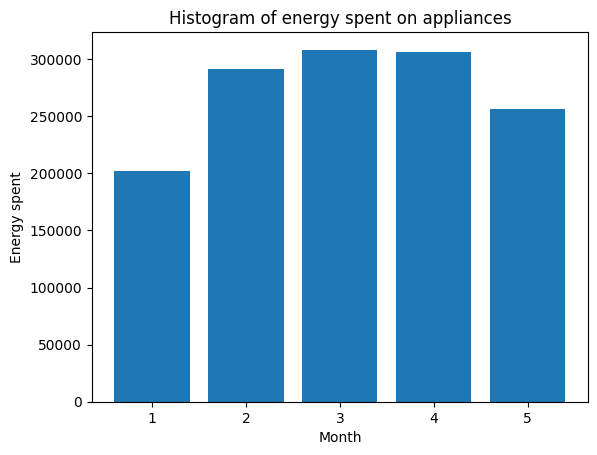

In [17]:
(x_values, y_values) = zip(*hist_elect)
plt.bar(x_values, y_values)
plt.title('Histogram of energy spent on appliances')
plt.xlabel('Month')
plt.ylabel('Energy spent')
plt.show()

In [18]:
test(hist_elect, [(1.0, 202120.0),  (2.0, 291800.0), (3.0, 308330.0), (4.0, 306300.0), (5.0, 256110.0)], 'Try it again!')

Test passed.


Surprisingly, we don't seem to have all the data from the 1st of January as we have less consumption in that particular month. Let's check the number of data points in each month.

In [19]:
examples_per_month = df_train.select(
    sql_f.col('month')
).groupBy(
    sql_f.col('month')
).count()\
.orderBy('month')\
.collect()

In [20]:
test(examples_per_month, [(1.0, 2033), (2.0, 2935), (3.0, 3121), (4.0, 3090), (5.0, 2737)], 'Try it again!')

Test passed.


We have less examples for both January and May. So probably the month is not a good feature, don't you think? Even if we have the same that for those months, it wouldn't make much sense to use it if we expect our model to predict future values in other months different than those. We are going to remove it from the DataFrame (and the training and test data frames too!).

In [95]:
# update the variables `df`, `df_train` and `df_test`, removing the column 'month'
df = df.drop('month')
df_train = df_train.drop('month')
df_test = df_test.drop('month')

In [22]:
test("month" in df.columns, False, "Column month has not been removed!")
test("month" in df_train.columns, False, "Column month has not been removed!")
test("month" in df_test.columns, False, "Column month has not been removed!")

Test passed.
Test passed.
Test passed.


You could do other plots to understand better the data and practice with Spark. This is a good opportunity to practice with the DataFrame API

In [23]:
# <FILL-IN WITH YOUR CODE>
# I will leave this part to practice for the exam, thank you for the suggestion :)

# Create a Pipeline with Spark ML

As you know, we can't feed the DataFrame directly to a machine learning algorithm, as we need to put all the input features as an Array, and indicate which one is the output feature (in our case, the 'Appliances' column!).

We will put together a simple Pipeline with the following stages:

- VectorAssembler: To combine all the input columns into a single vector column (i.e., all the columns but the 'Appliances' one.
- Learning algorithm: We feel like using Gradient-Boosted Trees [GBTs](https://en.wikipedia.org/wiki/Gradient_boosting) for this example, but feel free to use anything else.
- CrossValidator: We will use cross validation to tune the parameters of the GBT model. Yes, this can be added as part of a pipeline!  This is going to change the way we access the best model later!  

Step 1: Create the `VectorAssembler`:

In [36]:
from pyspark.ml.feature import VectorAssembler

feature_cols = df_train.columns
feature_cols.remove('Appliances')
print(feature_cols)

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'dayofyear', 'hour', 'year']


Step 2: Create an instance of `GBTRegressor` in which you don't indicate any parameters but the class label (i.e. `labelCol`) to 'Appliances'.

In [37]:
from pyspark.ml.regression import GBTRegressor

#name the variable `gbt` 
gbt = GBTRegressor(labelCol='Appliances')

Step 3: Create a `CrossValidator` for `gbt`.

You can explore the hyper-parameters you like for GBTs. Full documentation [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html). We would suggest to create a 'grid' for at least the depth of the tree and the number of iterations (e.g., we started with 10 and 20 iterations and the maximum depth at 5 and 8). If you are using your own computer, perhaps it is not a good idea to investigate more than 4-8 combinations.

Import the right libraries:

In [38]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [39]:
# define a variable `paramGrid` with some parameters, e.g. for maxDepth, range [5,8], and for maxIter [10,20]

paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxDepth, [5, 8])
    .addGrid(gbt.maxIter, [10, 20])
    .build()
)

Step 4: Create a `RegressionEvaluator`
 that uses the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as our performance metric. Import the right package first:

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator

In [41]:
# create a variable `evaluator` with a rmse as metric for the prediction column given by `gbt`.
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol="Appliances", predictionCol="prediction"
)

We can now create a CrossValidator `cv` that uses the `gbt` as estimator, as well as the evaluator and grid we defined above.

In [42]:
cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    seed=42,
)

Step 5. Create a Pipeline (`pipeline`) that contains the two stages: `vectorAssembler` and `cv`

In [43]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, cv])

> You may have found this a little bit strange. In the book we did this the other way around. We created a `CrossValidator` that used the pipeline. Instead, in this example, we add the cross validation within the pipeline. We wanted to illustrate that this is also possible, just use the option that suits you best.

Step 6. Finally, `fit` the model, and store in a `pipeline_model` variable. This might take quite a bit of time!

In [45]:
pipeline_model = pipeline.fit(df_train)

25/12/10 19:45:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

It could be a good idea to save the `pipelineModel` to disk, in case it takes too long, so we can read it later. You should explore the [Pipeline API](https://spark.apache.org/docs/3.3.0/api/python/reference/api/pyspark.ml.PipelineModel.html#pyspark.ml.PipelineModel) to find out how to do this.

In [50]:
MODEL_PATH = 'GBT_pipeline_model'

In [51]:
import os

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)
    pipeline_model.save(os.path.join(os.getcwd(), MODEL_PATH))

# Evaluate the results

To obtain the predictions in the test set, apply the method `transform()` of the trained pipeline on the test DataFrame! This step will not apply the cross-validation, it will simply use the best model from the training stage.

In [53]:
from pyspark.ml import PipelineModel
pipeline_model = PipelineModel.load(MODEL_PATH)

In [56]:
# create a variable `predictions`:

predictions = pipeline_model.transform(df_test)
predictions.show()

+----------+------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+---------+------+---------+---------+---------+---------+---------+---------+-----------+---------+---------+----------+----------+---------+---------+---------+----+------+--------------------+------------------+
|Appliances|lights|       T1|     RH_1|       T2|     RH_2|       T3|     RH_3|       T4|     RH_4|       T5|     RH_5|        T6|     RH_6|    T7|     RH_7|       T8|     RH_8|       T9|     RH_9|    T_out|Press_mm_hg|   RH_out|Windspeed|Visibility| Tdewpoint|      rv1|      rv2|dayofyear|hour|  year|            features|        prediction|
+----------+------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+---------+------+---------+---------+---------+---------+---------+---------+-----------+---------+---------+----------+----------+---------+---------+---------+----+------+---------

It is easier to view the results when we limit the columns displayed to:

- `Appliances`: the consumption of the Appliances in Wh
- `prediction`: our predicted prediction

Find a way to show the output only for these two features (only for the first 5 rows):

In [57]:
predictions.select(
    sql_f.col('Appliances'),
    sql_f.col('prediction')
).show(5)

+----------+------------------+
|Appliances|        prediction|
+----------+------------------+
|      10.0| 35.78382556820218|
|      10.0| 65.89737997141945|
|      20.0| 35.78382556820218|
|      20.0| 35.72257325721784|
|      20.0|34.657697995665046|
+----------+------------------+
only showing top 5 rows


Are these results any good? Let's compute the RMSE using the evaluator we created before! Store the result in a `rmse` variable.

In [58]:
rmse = evaluator.evaluate(predictions)

In [60]:
rmse

80.60133286252282

Seems a bit high?  Well, this number is relatively close to what it is reported in the original paper with RandomForest (RMSE around 69). But maybe you can investigate a bit more if you can improve that. Can you find out the importance of the features from the GBTs?  

We first need to find out the best model!! In the way we trained the pipeline, you can find the trained model as one of the stages of the `pipeline_model`. Store it in a variable `cv_model`:

In [61]:
pipeline_model.stages

[VectorAssembler_20484537f9de, CrossValidatorModel_ade2fa47a952]

In [66]:
cv_model = pipeline_model.stages[1].bestModel

Check the feature importances of that `cv_model`:

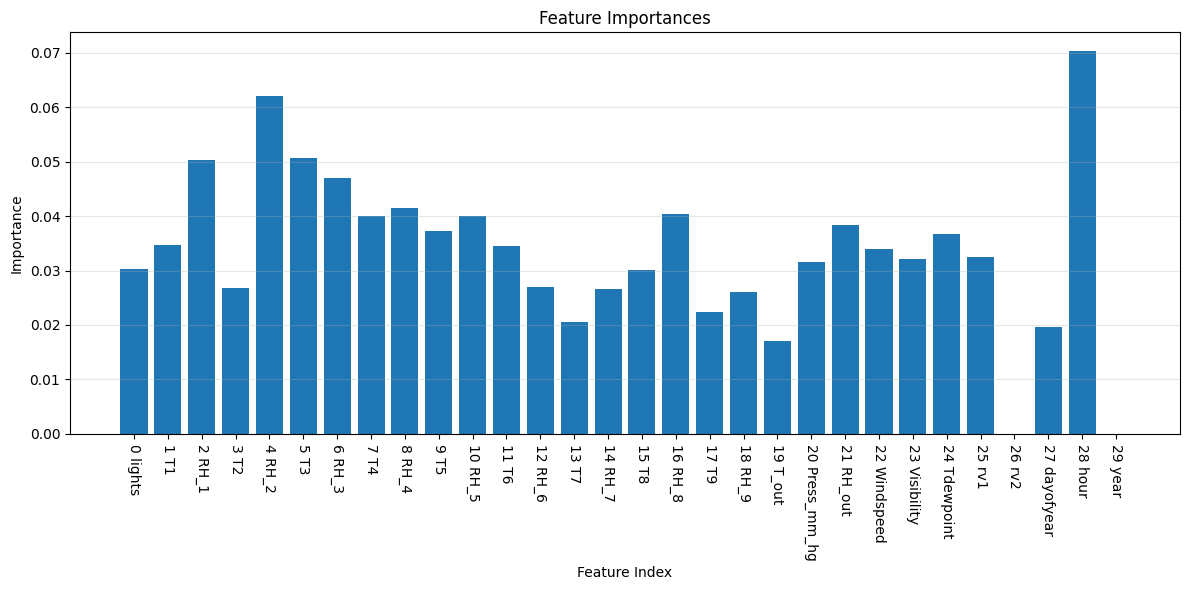

In [87]:
feat_importances = cv_model.featureImportances.toArray()
feat_indexes = []
for idx, feat in enumerate(feature_cols):
    feat_indexes.append(f"{idx} {feat}")

plt.figure(figsize=(12, 6))
plt.bar(feat_indexes, feat_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(range(len(feat_importances)), rotation=-90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Uhm, looks like our model gave the hour of the day (feature #28) quite a bit of importance. The random features ('rv1' and 'rv2', numbered, #25 and #26) were given different importance. While the model noticed that 'rv2' was completely useless, it gave some importance to 'rv1'. 

GBTs perform somehow an implicit feature selection, so those low-importance features won't affect much their performance, but we wonder if we could just remove low-importance features?

Create a list of those features with less than for example 0.05. 

In [89]:
# create a list `to_remove` that contains the feature names that must be removed because their confidence is less than 0.05 
indexes = [idx for idx, importance in enumerate(feat_importances) if importance < 0.05]
to_remove = [feature for idx, feature in enumerate(assembler.getInputCols()) if idx in indexes]
to_remove

['lights',
 'T1',
 'T2',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'rv1',
 'rv2',
 'dayofyear',
 'year']

# Removing low-importance features 

Check the current schema of the training data:

In [96]:
df_train.printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

You don't need to remove the columns from train and test partitions as you won't be able to re-train the pipeline without modifying the `VectorAssembler`. You simply need to indicate the columns you want to use when creating a new `vectorAssembler2`:

In [100]:
for feature in to_remove:
    if feature in feature_cols:
        feature_cols.remove(feature)
print(feature_cols)

vectorAssembler2 = VectorAssembler(inputCols=feature_cols, outputCol="features")

['RH_1', 'RH_2', 'T3', 'hour']


and create a new pipeline, `pipeline2`, with that new `vectorAssembler2`: 

In [101]:
pipeline2 = Pipeline(stages=[vectorAssembler2, cv])

And `fit` the new pipeline:

In [102]:
MODEL_PATH = 'GBT_pipeline_model_2'

In [108]:
pipeline_model_2 = pipeline2.fit(df_train)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)
    pipeline_model_2.save(os.path.join(os.getcwd(), MODEL_PATH))

Finally, make predictions and compute the error:

In [109]:
pipeline_model_2 = PipelineModel.load(MODEL_PATH)
predictions = pipeline_model_2.transform(df_test)

In [110]:
rmse = evaluator.evaluate(predictions)
rmse

85.96129664705492

Check the features of the best model and feature importances:

In [111]:
best_model = pipeline_model_2.stages[1].bestModel

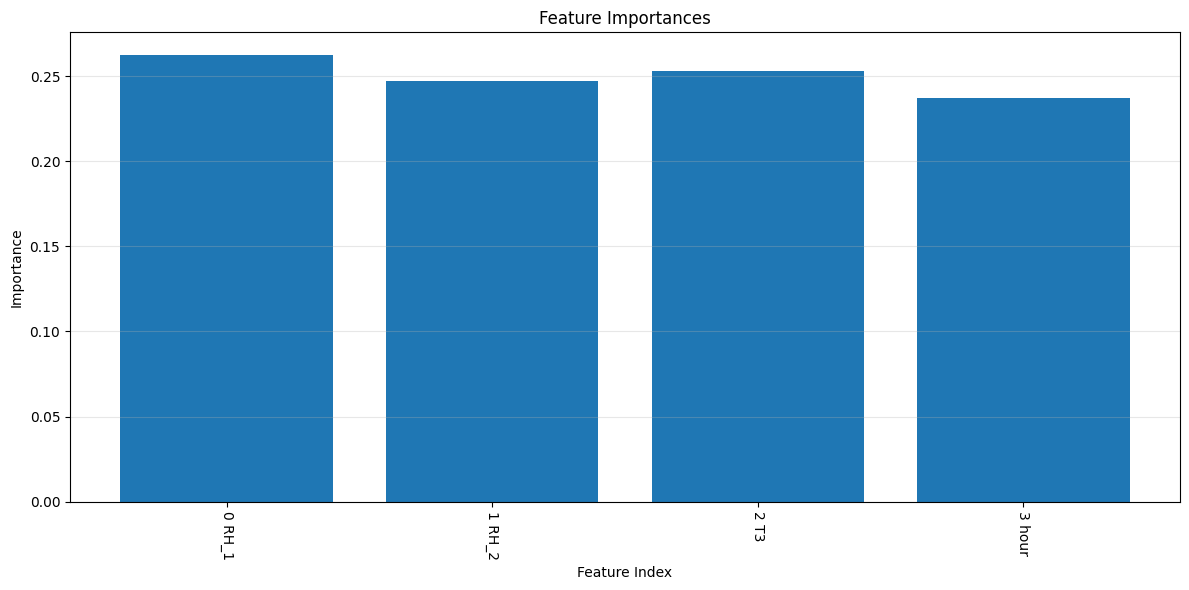

In [112]:
feat_importances = best_model.featureImportances.toArray()
feat_indexes = []
for idx, feat in enumerate(vectorAssembler2.getInputCols()):
    feat_indexes.append(f"{idx} {feat}")

plt.figure(figsize=(12, 6))
plt.bar(feat_indexes, feat_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(range(len(feat_importances)))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Check the feature importances of that `cv_model2`:

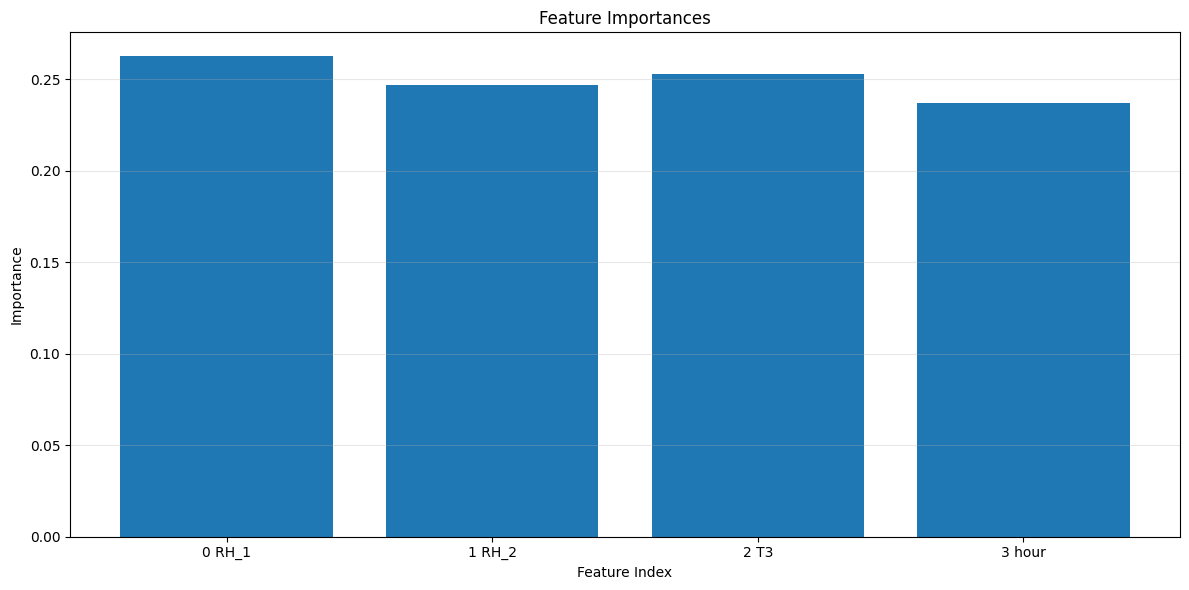

In [113]:
feat_importances = best_model.featureImportances.toArray()
feat_indexes = []
for idx, feat in enumerate(vectorAssembler2.getInputCols()):
    feat_indexes.append(f"{idx} {feat}")

plt.figure(figsize=(12, 6))
plt.bar(feat_indexes, feat_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(range(len(feat_importances)))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In this case, you will probably get less performance than before (will depend on your training and test partitions), but this time our model only considered 3 input features! This might not have made our model more precise (because GBTs already ignored those features), but makes it more interpretable!

# Improving further your model

There might be many ways to improve the results we obtained here. 

A few ideas for you to think about:

- Hyper-parameter tuning: We have used a relatively small set of parameters, and we haven't investigated what happened in training and test partitions; Is there overfitting of the training? Would we be able to use a larger number of trees?
- The features of this dataset are numerical, are there other classifiers that may be more appropriate than GBTs?
- We haven't really done any careful pre-processing of the data. Are there outliers or noise that might be having an impact on the results? 
- Do we need any normalization?
- You can still try with different subsets of features. We recommend you to take a look at the original paper and borrow some ideas to improve.